# Lendingkart

In [1]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import gensim
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/lendingkart/lendingkart.csv')

In [3]:
# Company username
company_username = 'Lendingkart'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [6]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [7]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [9]:
qdf.shape

(1124, 28)

In [10]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 736


In [11]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [12]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [13]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

In [14]:
result

,conversation_id,response_time
0,1343785976942882818,0.888056
1,1344177960446640130,0.610278
2,1313373475407491073,2.497500
3,1343868209510850564,3.420278
4,1343518600808677381,0.000000
...,...,...
731,1097425529492393984,0.000000
732,1099926708210167808,7.112778
733,1096309397372817408,0.346111
734,1096031343539118080,0.000000


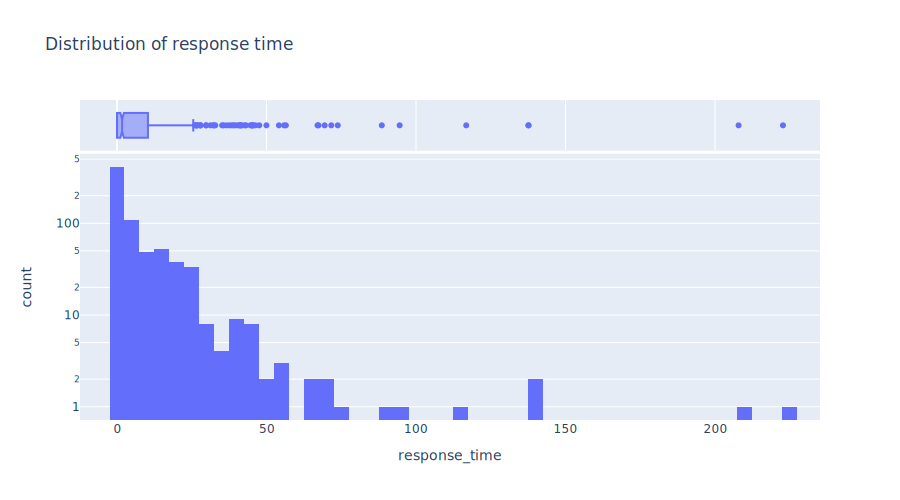

In [15]:
fig = px.histogram(result[result['response_time']<1000], x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [16]:
result['resolution_time'] = 0

In [17]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

In [18]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 547
Number of queries unresolved: 189


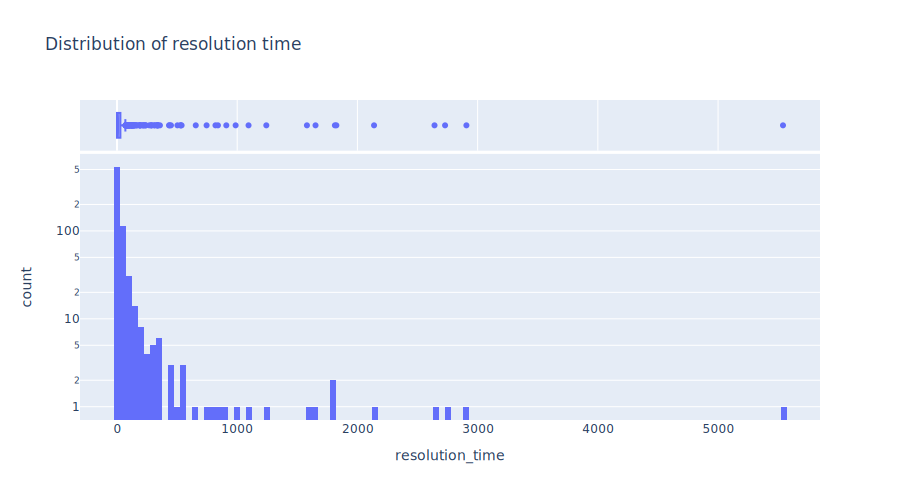

In [19]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [20]:
result.describe()

,response_time,resolution_time
count,736.000000,736.000000
mean,15.893941,71.104340
std,204.717685,324.559220
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.708194,4.345417
75%,10.396875,28.168056
max,5540.252222,5540.254722


## Query Tweets Topics

In [170]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[(queries['inReplyToTweetId'] == 'nan') & (queries['username'] != company_username)]

In [171]:
queries.shape

(512, 28)

In [172]:
processor = Processor('./../../data/config.json')

In [179]:
# queries = processor.preprocess_individual(queries)
pre_queries, post_queries = processor.preprocess(queries)

In [182]:
# Create dictionaries
pre_id2word = gensim.corpora.Dictionary(pre_queries['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_queries['bigram'].values.tolist())

In [183]:
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_queries['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_queries['bigram'].values.tolist()]

In [180]:
pre_queries.shape

(26, 31)

In [181]:
post_queries.shape

(440, 31)

In [194]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')

In [195]:
pre_coherence_model = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_queries['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_model_score = pre_coherence_model.get_coherence()
print('Pre-COVID coherence Score: ', pre_coherence_model_score)

Pre-COVID coherence Score:  -14.375755563142514


In [196]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(pre_lda_model, pre_corpus, pre_id2word)
LDAvis_prepared

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.064180  0.069740       1        1  41.002258
2     -0.098375  0.015774       2        1  39.292177
1      0.034195 -0.085514       3        1  19.705565, topic_info=         Term      Freq     Total Category  logprob  loglift
49    service  2.000000  2.000000  Default  30.0000  30.0000
51   customer  3.000000  3.000000  Default  29.0000  29.0000
48         rd  1.000000  1.000000  Default  28.0000  28.0000
46      class  1.000000  1.000000  Default  27.0000  27.0000
32       loan  9.000000  9.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
65    request  0.601780  1.628873   Topic3  -4.5773   0.6285
47        ill  0.601394  1.629008   Topic3  -4.5780   0.6278
97  receiving  0.599542  1.629666   Topic3  -4.5811   0.6243
4        guys  0.599121  1.621460   Topic3  -4.5818   0.6287
98   rejected  0.598992  2.239913   Topic3  -4.5820   0.3053

[150 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
130       2  0.854889       account
150       1  0.848716         agent
67        1  0.860060   application
67        3  0.286687   application
93        3  0.988616  applications
...     ...       ...           ...
99        3  0.988690  unsubscribed
169       1  0.556603          upto
128       3  0.988149      whatsapp
100       3  0.988748          wont
129       3  0.988149          work

[136 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [197]:
pre_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=pre_lda_model, 
                                                         corpus=pre_corpus, 
                                                         texts=pre_queries['bigram'].values.tolist(),
                                                         tweets=pre_queries['tweet'].values.tolist())

# pre_queries_topic_sents_keywords.dropna(axis=0, inplace=True)

In [199]:
pre_queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['loan, gaurav, disbursal, know, start, let, approved, docs, cheque, dsa',
       'service, customer, rd, class, number, email, happen, request, ill, benny',
       'loan, application, team, id, business, approved, good, time, lai, upto'],
      dtype=object)

Pre-COVID Topics that can be found are:
1. General asks like website problems, erroneous deductions etc.
2. Problems in loan processing
3. Undesirable actions complaints

In [168]:
# select = pre_queries_topic_sents_keywords['Topic_Keywords'].unique()[2]
# pre_queries_topic_sents_keywords[pre_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

array(['@Lendingkart not a good brand as I thought, intensionally delaying business loan therefore my project going late too..\n\nWorst experience',
       '@Lendingkart \n\nDear team,\nQuickly complete the process of my application.\nDetails are below.\nLAI102664621',
       '@Lendingkart could you please remove my phone number and email id from your list.',
       '@Lendingkart\nDear Lendingkart Team,\nWe have take a loan from your company.\xa0\nWhy are you update my loan status in settlement While I have paid all EMI on time.\nMy Loan id is LAI-00014964- Balaji Autos.',
       'Got this msg from @Lendingkart \n\nCongrats! Your Collateral-FREE Business loan of upto Rs.9899543 is approved.\n\nSubmit your details &gt;&gt; https://t.co/dBk9Kbrwil\n\nHow cheap!',
       "@Lendingkart\nHi, Ref ID. 05/11/Dxxx62. You're application for Business Loan of upto Rs.8626945 is approved. \n\nCheck your LoanAmount &gt;&gt; https://t.co/JpcBPmvfGJ\n\nHi team I receiving this fake sms from couple of 

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



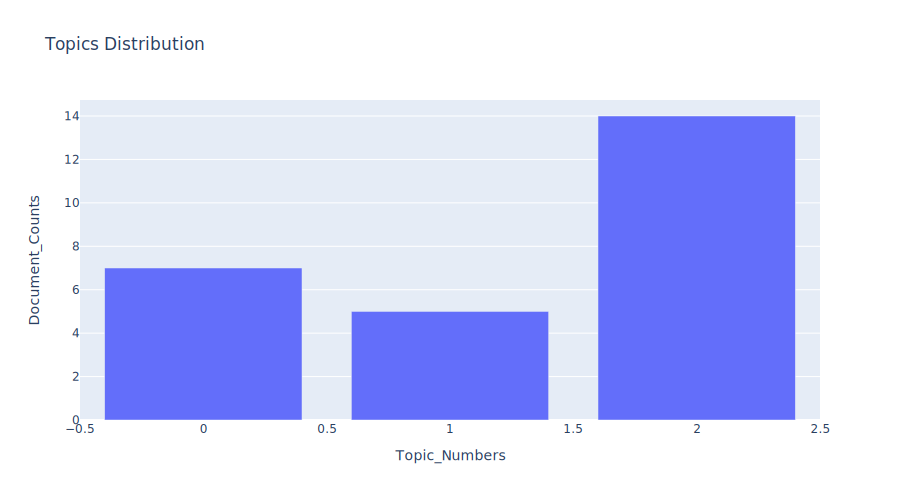

In [169]:
pre_queries_dist, fig = processor.plot_topic_distribution(pre_queries_topic_sents_keywords)
fig.show()

In [208]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=2,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')
post_coherence_model = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_queries['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_model_score = post_coherence_model.get_coherence()
print('Post-COVID coherence Score: ', post_coherence_model_score)


Post-COVID coherence Score:  -4.090643576540043


In [209]:

import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(post_lda_model, post_corpus, post_id2word)
LDAvis_prepared


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.062582  0.0       1        1  51.372352
1     -0.062582  0.0       2        1  48.627648, topic_info=         Term       Freq      Total Category  logprob  loglift
125  business  31.000000  31.000000  Default  30.0000  30.0000
336   account  36.000000  36.000000  Default  29.0000  29.0000
341    cheque  13.000000  13.000000  Default  28.0000  28.0000
32      reply  28.000000  28.000000  Default  27.0000  27.0000
215     apply   9.000000   9.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
45    request  11.598459  29.216256   Topic2  -5.5427  -0.2029
184     mails   9.405313  15.377240   Topic2  -5.7523   0.2294
320       day   9.530390  17.683703   Topic2  -5.7391   0.1028
139     month  10.124084  29.215972   Topic2  -5.6787  -0.3388
153       rbi   9.971091  33.059997   Topic2  -5.6939  -0.4777

[161 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
336       1  0.840033       account
336       2  0.162587       account
575       2  0.780379       advance
259       1  0.867163   application
259       2  0.173433   application
...     ...       ...           ...
279       2  0.578053            ur
1380      1  0.975567  village_want
318       1  0.493343          want
318       2  0.493343          want
1560      2  0.928990         years

[189 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [210]:
post_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=post_lda_model, 
                                                         corpus=post_corpus, 
                                                         texts=post_queries['bigram'].values.tolist(),
                                                         tweets=post_queries['tweet'].values.tolist())


In [211]:

post_queries_topic_sents_keywords['Topic_Keywords'].unique()


array(['emi, moratorium, loan, account, business, rbi, mail, response, pay_emi, month',
       'loan, moratorium, emi, time, mail, reply, times, pay, dont, ecs'],
      dtype=object)

Post-COVID two topics prevail:
1. Ask for moratorium
2. Issues with moratorium process

In [212]:
select = post_queries_topic_sents_keywords['Topic_Keywords'].unique()[0]
post_queries_topic_sents_keywords[post_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values


array(['@Lendingkart Hi. My company has been in touch with a LendingKart representative. This rep has been extremely rude and unprofessional. Wanted to bring this to your notice. Please DM me for more details.',
       '@Lendingkart Makes people cibil score down by collecting their documents without providing any loan @PMOIndia @rsprasad @Anurag_Office',
       '@Lendingkart please stop sending SMS and emails.\nThanks',
       '@Lendingkart Your customer service is so screwed that you beat even the SBIs of the world. My loan got approved and for the last 18 days I have been chasing you guys to finalize the process &amp; disburse the amount, but to no avail. (Part 1)',
       '@Lendingkart And it\'s just impossible to talk to anyone in your team. The low-level execs are unimaginably rude and are available only at their convenience, and the only response you get by mailing to you is that "A ticket has been created". (Part 2)',
       '@Lendingkart I attached bank statement and rectified 

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



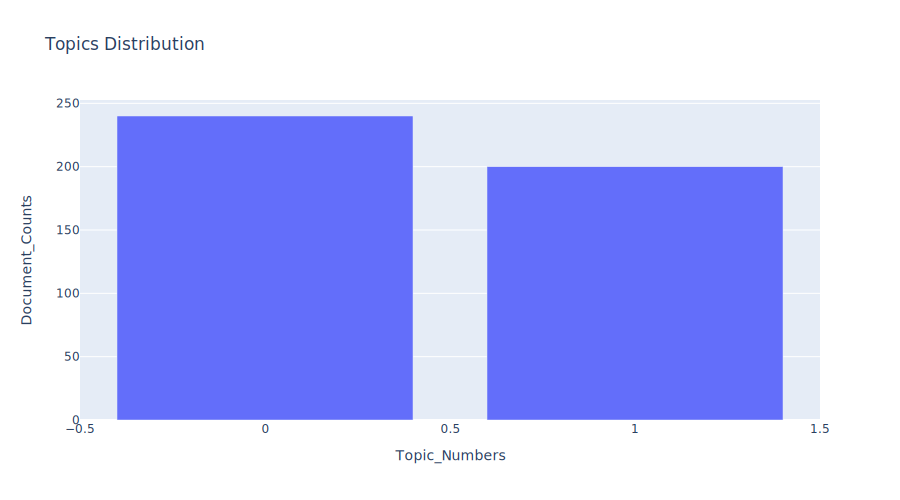

In [213]:
post_queries_dist, fig = processor.plot_topic_distribution(post_queries_topic_sents_keywords)
fig.show()